In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls "/gdrive/My Drive/Final Project (8th Sem)/Frame_prediction_kitti/Train/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/
0000000000.png	0000000006.png	0000000012.png	0000000018.png	0000000024.png
0000000001.png	0000000007.png	0000000013.png	0000000019.png	0000000025.png
0000000002.png	0000000008.png	0000000014.png	0000000020.png	0000000026.png
0000000003.png	0000000009.png	0000000015.png	0000000021.png	0000000027.png
0000000004.png	0000000010.png	0000000016.png	0000000022.png
0000000005.png	0000000011.png	0000000017.png	0000000023.png


In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers.core import RepeatVector, Permute
from scipy import ndimage, misc
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [ ]:
X = []
names = os.listdir('/gdrive/My Drive/Frame_prediction_kitti/Train/')
names.sort()
print(names)
for filename in names:
    print(filename)
    img = cv2.imread('/gdrive/My Drive/Frame_prediction_kitti/Train/'+filename, 0)
   # plt.imshow(img)
    X.append(img)
    #plt.show()
X = np.array(X, dtype=float)
print("##################")
# for ele in X:
#   plt.imshow(ele)
#   plt.show()
Xtrain = 1.0/255*X

['0000000000.png', '0000000001.png', '0000000002.png', '0000000003.png', '0000000004.png', '0000000005.png', '0000000006.png', '0000000007.png', '0000000008.png', '0000000009.png', '0000000010.png', '0000000011.png', '0000000012.png', '0000000013.png', '0000000014.png', '0000000015.png', '0000000016.png', '0000000017.png', '0000000018.png', '0000000019.png', '0000000020.png', '0000000021.png', '0000000022.png', '0000000023.png', '0000000024.png', '0000000025.png', '0000000026.png', '0000000027.png']
0000000000.png
0000000001.png
0000000002.png
0000000003.png
0000000004.png
0000000005.png
0000000006.png
0000000007.png
0000000008.png
0000000009.png
0000000010.png
0000000011.png
0000000012.png
0000000013.png
0000000014.png
0000000015.png
0000000016.png
0000000017.png
0000000018.png
0000000019.png
0000000020.png
0000000021.png
0000000022.png
0000000023.png
0000000024.png
0000000025.png
0000000026.png
0000000027.png
##################


(28, 512, 1392)


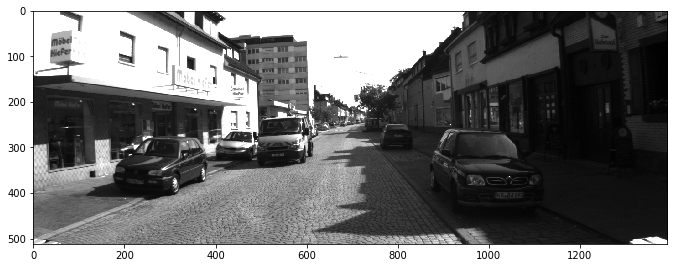

In [ ]:
print(Xtrain.shape)
plt.figure(figsize=[25,25])

plt.subplot(121)
curr_img = np.reshape(Xtrain[0], (512,1392))
#curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')

In [ ]:
Xtrain= Xtrain.reshape(-1, 512,1392, 1)
print(Xtrain.shape)

(28, 512, 1392, 1)


In [ ]:

train_X = Xtrain[:22]
valid_X = Xtrain[22:]
train_ground = Xtrain[:22]
valid_ground = Xtrain[22:]
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)

(22, 512, 1392, 1)
(6, 512, 1392, 1)
(22, 512, 1392, 1)
(6, 512, 1392, 1)


In [ ]:
plt.figure(figsize=(150, 150))
print("Origiinal image")
for i in range(10):
      plt.subplot(2, 10, i+1)
      plt.imshow(train_X[i, ..., 0], cmap='gray') 
plt.show() 

In [ ]:
batch_size = 2
epochs = 100
inChannel = 1
x, y = 512, 1392
input_img = Input(shape = (x, y, inChannel))
decoder_input= Input(shape = ((64,174,256)))

In [ ]:
def encoder(input_img):
    conv1 = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #256 x 696 x 128
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #128 x 348 x 128
    conv3 = Conv2D(256, (3, 3), activation='tanh', padding='same')(pool2) #128 x 348 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #64 x 174 x 256
    return pool3

def decoder(decoder_input):
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder_input) 
    up1 = UpSampling2D((2,2))(conv5) #64 x 174 x 128
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) #128 x 248 x 128
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) # 256 x 692 x 128
    decoded = Conv2D(1, (7, 7), activation='relu', padding='same')(up3)
    return decoded


In [ ]:
encoder = Model(input_img, encoder(input_img))
decoder = Model(decoder_input, decoder(decoder_input))
encoder.summary()
decoder.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1392, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 1392, 128)    6400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 696, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 696, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 348, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 348, 256)     295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 174, 256)      0

In [ ]:
encoded = encoder(input_img)
decoded = decoder(encoded)
print(encoded)
print(decoded)
auto_encoder = Model(input_img, decoded)
print(auto_encoder)
auto_encoder.compile(loss='mean_squared_error', optimizer = RMSprop())
auto_encoder.summary()

Tensor("model_1/max_pooling2d_3/MaxPool:0", shape=(?, 64, 174, 256), dtype=float32)
Tensor("model_2/conv2d_7/Relu:0", shape=(?, 512, 1392, 1), dtype=float32)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1392, 1)      0         
_________________________________________________________________
model_1 (Model)              (None, 64, 174, 256)      449152    
_________________________________________________________________
model_2 (Model)              (None, 512, 1392, 1)      596481    
Total params: 1,045,633
Trainable params: 1,045,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:

autoencoder_train = auto_encoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))





Train on 22 samples, validate on 6 samples
Epoch 1/100





22/22 [==============================] - 35s 2s/step - loss: 301.8768 - val_loss: 0.0228
Epoch 2/100
22/22 [==============================] - 14s 638ms/step - loss: 0.0272 - val_loss: 0.0319
Epoch 3/100
22/22 [==============================] - 14s 636ms/step - loss: 0.0211 - val_loss: 0.0183
Epoch 4/100
22/22 [==============================] - 14s 635ms/step - loss: 0.0260 - val_loss: 0.0433
Epoch 5/100
22/22 [==============================] - 14s 635ms/step - loss: 0.0310 - val_loss: 0.0366
Epoch 6/100
22/22 [==============================] - 14s 635ms/step - loss: 0.0483 - val_loss: 0.0161
Epoch 7/100
22/22 [==============================] - 14s 634ms/step - loss: 0.0254 - val_loss: 0.0325
Epoch 8/100
22/22 [==============================] - 14s 632ms/step - loss: 0.0342 - val_loss: 0.0133
Epoch 9/100
22/22 [==============================] - 14s 633ms/step - loss: 0.0700 - val_loss: 0.0338
Epoch 10/100
22/22 [============

In [ ]:
def decoder_final(code_combined):
    conv_dec_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(code_combined) 
    conv_dec_2 = UpSampling2D((2,2))(conv_dec_1) #128 x 348 x 1024
    conv_dec_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_dec_2) 
    conv_dec_4 = UpSampling2D((2,2))(conv_dec_3) # 256 x 692 x 256
    decoded = Conv2D(1, (7, 7), activation='tanh', padding='same')(conv_dec_4) 
    up3 = UpSampling2D((2,2))(decoded)# 512 x 1392 x 256
    #decoded_2 = Conv2D(1, (7, 7), activation='tanh', padding='same')(up3)
    #up4 = UpSampling2D((2,2))(decoded_2)# 512 x 1392 x 256
    return up3
#train_x = 22 images 
#valid_x = 6 images
pred = encoder.predict(valid_X)
print(pred.shape)


def add_code_layers(frame_list):
  temp=np.zeros((64,174,256))
  for frame in frame_list:
    temp = np.add(temp,frame)
  temp=(1.0/(255*4))*temp
  return temp

(6, 64, 174, 256)


In [ ]:
train_X_new = Xtrain[:21]
label_X_new = Xtrain[4:19]
test_X_new = Xtrain[16:25]
train_label_new = Xtrain[6:10]
test_label_new = Xtrain[20,24]
print(train_X.shape)
print(label_X_new.shape)
print(test_X_new.shape)
print(test_label_new.shape)

(22, 512, 1392, 1)
(15, 512, 1392, 1)
(9, 512, 1392, 1)
(1392, 1)


In [ ]:
def encoded_combined(train_X_new,start,stop):
  train_new_encoded_list = []
  for i in range(start,stop):
    temp = train_X[i:i+4]
    lis=[]
    for j in temp:
      j=j.reshape(-1,512,1392,1)
      print(encoder.predict(j).shape)
      lis.append(encoder.predict(j)[0])

    train_new_encoded_list.append(add_code_layers(lis))
  return np.asarray(train_new_encoded_list)  


In [ ]:
tmp = encoded_combined(train_X_new,0,15)

(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 17

In [ ]:
print(tmp.shape)
input_combined= Input(shape = (64,174,256))
decoder_combined = Model(input_combined,decoder_final(input_combined))
decoder_combined.compile(loss="mean_squared_error",optimizer=RMSprop())
decoder_combined.summary()


(15, 64, 174, 256)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 174, 256)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 174, 512)      1180160   
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 128, 348, 512)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 348, 256)     1179904   
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 256, 696, 256)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 696, 1)       12545     
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 512,

In [ ]:
auto_encoder_final = decoder_combined.fit(tmp,label_X_new,batch_size=batch_size,epochs=100,verbose=1)


Epoch 1/100
15/15 [==============================] - 13s 881ms/step - loss: 0.1779
Epoch 2/100
15/15 [==============================] - 5s 314ms/step - loss: 0.0707
Epoch 3/100
15/15 [==============================] - 5s 314ms/step - loss: 0.0470
Epoch 4/100
15/15 [==============================] - 5s 311ms/step - loss: 0.0514
Epoch 5/100
15/15 [==============================] - 5s 314ms/step - loss: 0.0400
Epoch 6/100
15/15 [==============================] - 5s 312ms/step - loss: 0.0478
Epoch 7/100
15/15 [==============================] - 5s 311ms/step - loss: 0.0400
Epoch 8/100
15/15 [==============================] - 5s 310ms/step - loss: 0.0427
Epoch 9/100
15/15 [==============================] - 5s 311ms/step - loss: 0.0387
Epoch 10/100
15/15 [==============================] - 5s 309ms/step - loss: 0.0431
Epoch 11/100
15/15 [==============================] - 5s 313ms/step - loss: 0.0373
Epoch 12/100
15/15 [==============================] - 5s 309ms/step - loss: 0.0414
Epoch 13/100

In [ ]:
  # temp_list.append(encoder.predict(frame.reshape(-1,512,1392,1)))
  # pred_dec=encoder.predict(frame.reshape(-1,512,1392,1))
  # final_pred = decoder_combined.predict(add_code_layers(np.asarray(temp_list)))
tmp_pred = encoded_combined(train_X_new,2,6)
tmp.shape

(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)
(1, 64, 174, 256)


(4, 64, 174, 256)

The input sequence  2 3 4 5


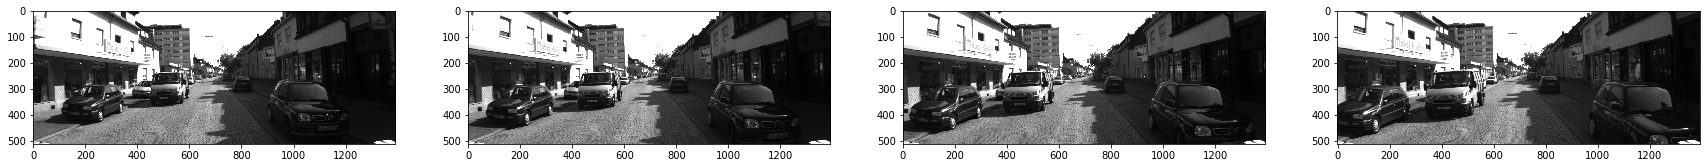

Predicted Output for the sequence is 


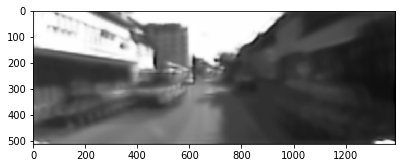

Original Output for the sequence is 


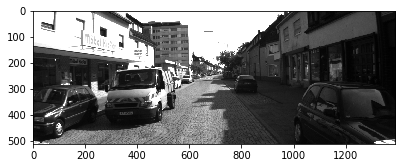

The input sequence  3 4 5 6


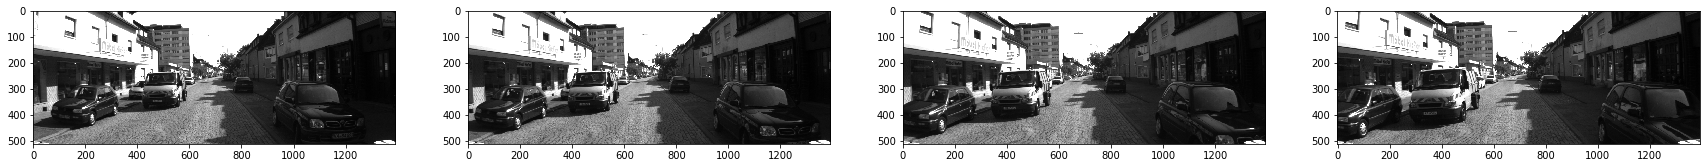

Predicted Output for the sequence is 


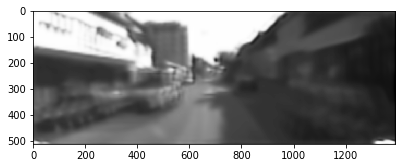

Original Output for the sequence is 


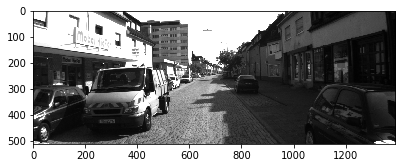

The input sequence  4 5 6 7


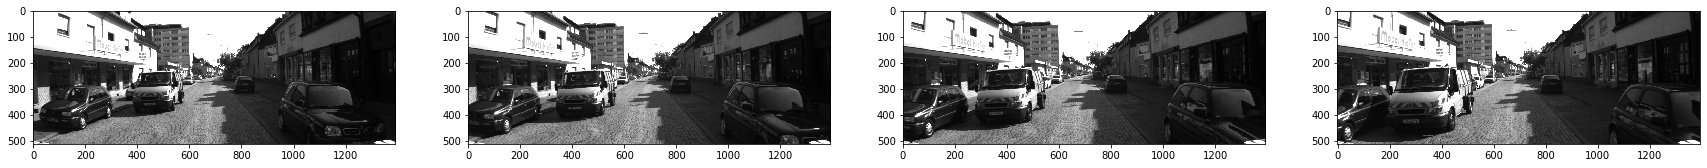

Predicted Output for the sequence is 


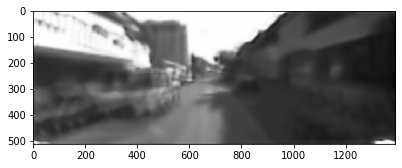

Original Output for the sequence is 


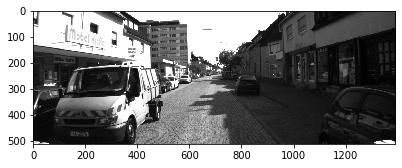

The input sequence  5 6 7 8


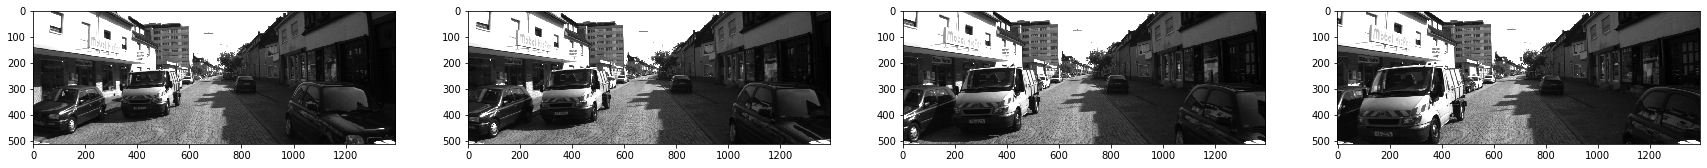

Predicted Output for the sequence is 


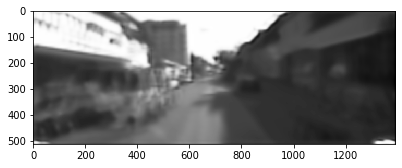

Original Output for the sequence is 


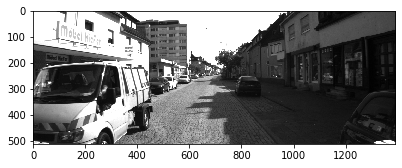

In [ ]:
final_pred = decoder_combined.predict(tmp)
for i in range(2,6):
  print("The input sequence ",i,i+1,i+2,i+3)
  plt.figure(figsize=(100, 100))
  for j in range(i,i+4):
    plt.subplot(2,13,j+1)
    plt.imshow(train_X_new[j,...,0],cmap='gray')
  plt.show()
  print("Predicted Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(final_pred[(i-2),...,0],cmap='gray')
  plt.show()
  print("Original Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(train_label_new[(i-2),...,0],cmap='gray')
  plt.show()